In [2]:
#The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. 
# Accordingly, you should filter out all rows with type TIPS Note or TIPS bond.

In [3]:
#file path to data file
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
import seaborn
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FormatStrFormatter)

quotes = pd.read_excel("treasury_quotes_2025-11-28.xlsx",sheet_name='selected quotes').set_index('KYTREASNO')
#quotes = quotes[~quotes['type'].isin(['note', 'bond'])]


In [4]:
def calc_cpn_rate(quote_date, maturity_date):
    # Generate coupon dates
    semiannual_offset = pd.DateOffset(months=6)
    dates = []
    current_date = maturity_date

    while current_date > quote_date:
        dates.append(current_date)
        current_date -= semiannual_offset

    # Return sorted dates in ascending order
    return sorted(dates)


### 1.1 Create the cashflow matrix, C, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of $100.

In [5]:
QUOTE_DATE = quotes['quote date'].iloc[0]
t_date = pd.to_datetime(QUOTE_DATE)
CF = pd.DataFrame(data=0, index=quotes.index, columns=quotes['maturity date'])

for i in quotes.index:
    coupon_dates = calc_cpn_rate(t_date,pd.to_datetime(quotes.loc[i,'maturity date']))

    if coupon_dates is not None:
        CF.loc[i,coupon_dates] = quotes.loc[i,'cpn rate']/2

    CF.loc[i,quotes.loc[i,'maturity date']] += 100

CF = CF.resample('m',axis=1).sum()
CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)
CF = CF.fillna(0).sort_index(axis=1)
CF = CF.loc[:, CF.sum(axis=0) > 0]


/var/folders/gt/g_vf3xyx5lz99_bzcn46yqm80000gn/T/ipykernel_39505/2462199007.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.4375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quotes.loc[i,'cpn rate']/2
/var/folders/gt/g_vf3xyx5lz99_bzcn46yqm80000gn/T/ipykernel_39505/2462199007.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quotes.loc[i,'cpn rate']/2
/var/folders/gt/g_vf3xyx5lz99_bzcn46yqm80000gn/T/ipykernel_39505/2462199007.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.9375' has dtype incompatible with int64, please explicitly cast to a

In [6]:
CF = CF.iloc[:, :20]
CF

maturity date,2025-11-30,2026-05-31,2026-11-30,2027-05-31,2027-11-30,2028-05-31,2028-11-30,2029-05-31,2029-11-30,2030-05-31,2030-11-30,2031-05-31,2031-11-30,2032-05-31,2032-11-30,2033-05-31,2033-11-30,2034-05-31,2034-11-30,2035-05-31
KYTREASNO,,,,,,,,,,,,,,,,,,,,
208227,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000
208316,2.1250,2.1250,102.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000
208399,1.9375,1.9375,1.9375,101.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000
208484,1.6875,1.6875,1.6875,1.6875,101.6875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000
208058,1.8125,1.8125,1.8125,1.8125,1.8125,101.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000
208145,2.1875,2.1875,2.1875,2.1875,2.1875,2.1875,102.1875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000
208229,2.2500,2.2500,2.2500,2.2500,2.2500,2.2500,2.2500,102.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000
208318,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000
208401,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,102.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000


### 1.2 Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system: p = Cz

In [7]:
#function that converts discount factor to interest rate
def discount_to_intrate(discount, maturity, n_compound=None):
    if n_compound is None:
        intrate = - np.log(discount) / maturity
    else:
        intrate = n_compound * (1/discount**(1/(n_compound * maturity)) - 1)       
    return intrate

In [8]:
compounding = 2

df = pd.DataFrame(
    {
        "discount factor": np.linalg.solve(CF, quotes.loc[CF.index, "price"]),
        "ttm": quotes.loc[CF.index, "ttm"],
    }
).set_index("ttm")

df["rate"] = discount_to_intrate(
    df["discount factor"].values,
    df.index.values,
    n_compound=compounding
)

spot = df
spot



/var/folders/gt/g_vf3xyx5lz99_bzcn46yqm80000gn/T/ipykernel_39505/805805320.py:6: RuntimeWarning: invalid value encountered in power
  intrate = n_compound * (1/discount**(1/(n_compound * maturity)) - 1)


,discount factor,rate
ttm,,
0.503765,-153.397604,NaN
1.004791,4.631438,-1.067263
1.503080,4.080393,-0.747206
2.004107,3.735540,-0.560423
2.505133,3.320183,-0.425977
3.006160,3.435499,-0.371149
3.504449,3.875285,-0.351483
4.005476,3.876849,-0.311229
4.503765,3.555595,-0.262725


### 1.3 Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the… 
#### - discount factors
### Make another plot, this time with the vertical axis displaying the
#### - semiannually compounded discount rates
#### - continuously compounded discount rates



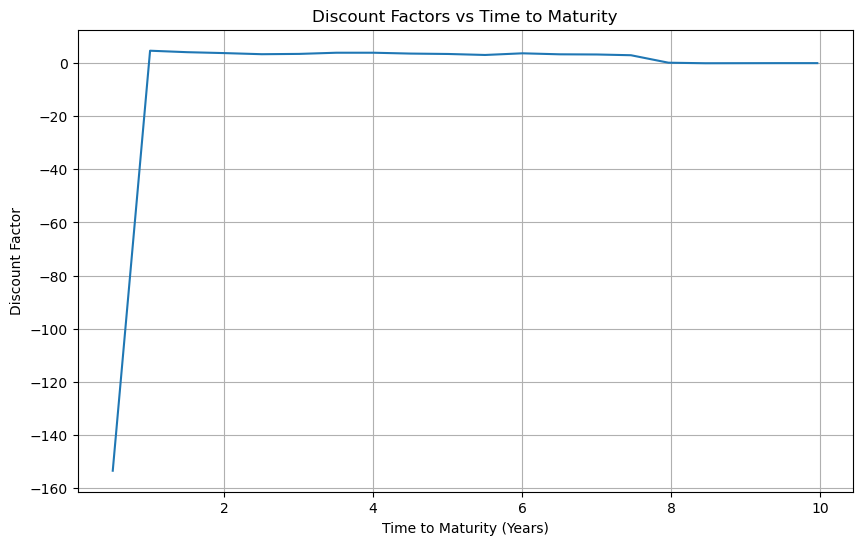

In [9]:
plt.figure(figsize=(10, 6))
spot['discount factor'].plot(linestyle='-')
plt.title('Discount Factors vs Time to Maturity')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Discount Factor')
plt.grid(True)
plt.show()

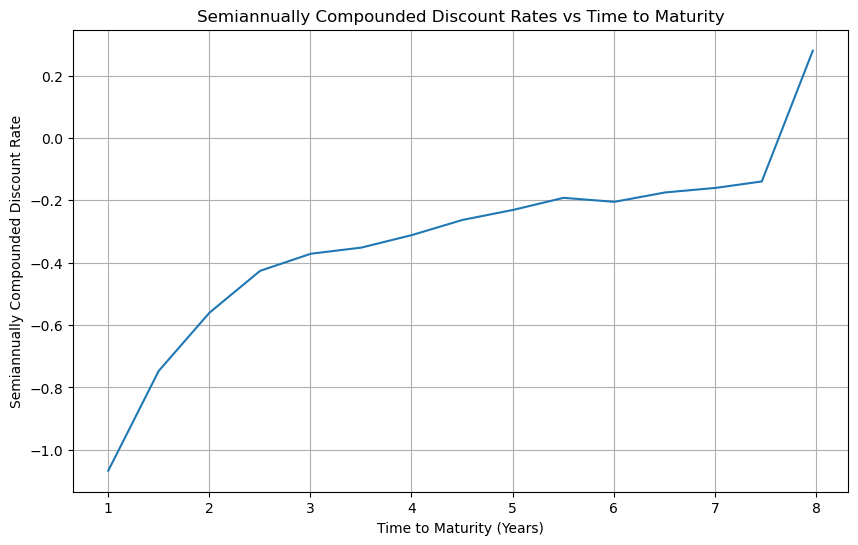

In [10]:
plt.figure(figsize=(10, 6))
spot['rate'].plot(linestyle='-')
plt.title('Semiannually Compounded Discount Rates vs Time to Maturity')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Semiannually Compounded Discount Rate')
plt.grid(True)
plt.show()

/var/folders/gt/g_vf3xyx5lz99_bzcn46yqm80000gn/T/ipykernel_39505/805805320.py:4: RuntimeWarning: invalid value encountered in log
  intrate = - np.log(discount) / maturity


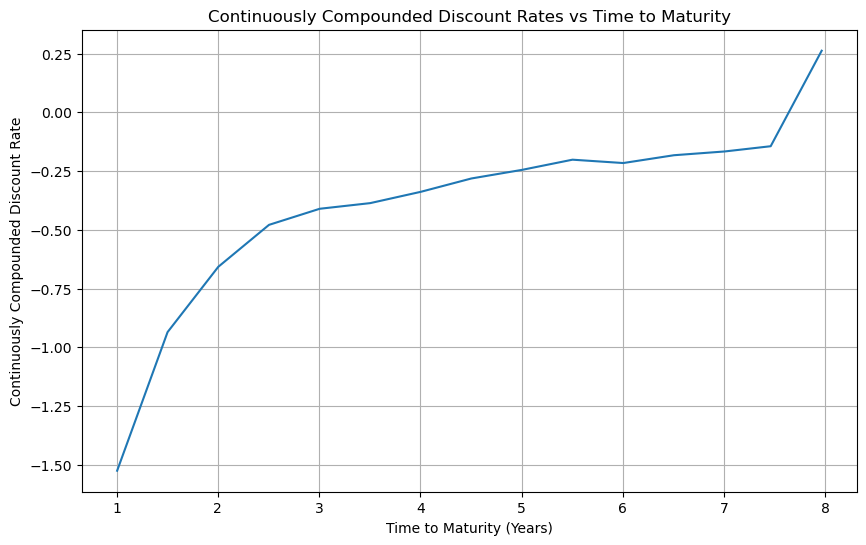

In [11]:
spot['cont_rate'] = discount_to_intrate(
    spot['discount factor'].values,
    spot.index.values,
    n_compound=None
) 
plt.figure(figsize=(10, 6))
spot['cont_rate'].plot(linestyle='-')
plt.title('Continuously Compounded Discount Rates vs Time to Maturity')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Continuously Compounded Discount Rate')
plt.grid(True)
plt.show()

### 1.4 Estimate the discount curve via the Nelson-Siegel model.
### Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices. Consider using minimize from scipy.optimize. When done, Report the estimated NS parameters. Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

Optimization success: True
SSE: 210820.55650002614
Estimated NS parameters:
  beta0=0.03000000
  beta1=-0.02000000
  beta2=0.02000000
  lambda=0.50000000


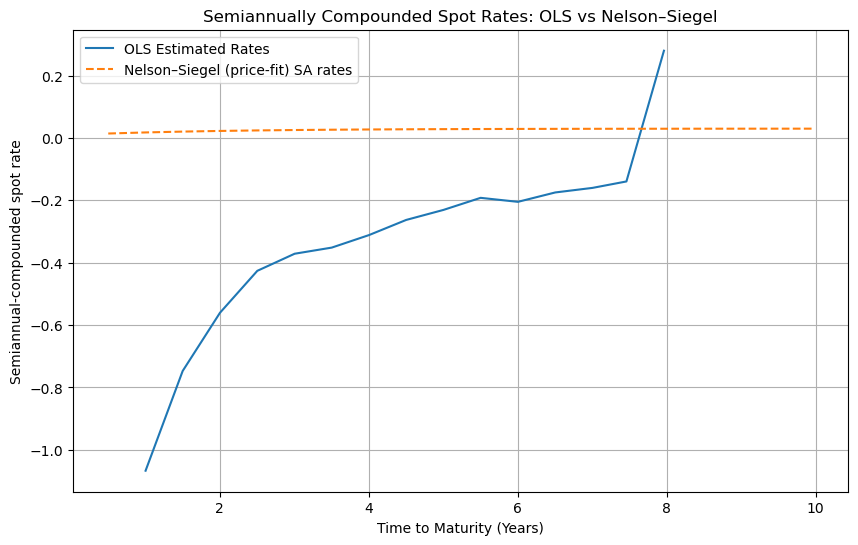

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def ns_spot_continuous(t, beta0, beta1, beta2, lam):
    """
    Nelson–Siegel continuously-compounded spot rate r(t).
    """
    t = np.asarray(t, dtype=float)
    x = lam * t

    # safe handling of t=0 (limit of (1-exp(-x))/x is 1)
    with np.errstate(divide="ignore", invalid="ignore"):
        A = np.where(x == 0.0, 1.0, (1.0 - np.exp(-x)) / x)

    return beta0 + beta1 * A + beta2 * (A - np.exp(-x))

def discounts_from_ns(t, beta0, beta1, beta2, lam):
    r = ns_spot_continuous(t, beta0, beta1, beta2, lam)
    return np.exp(-r * t)

def sa_spot_from_discount(D, t):
    """
    Convert discount factors to semiannual-compounded spot rates.
    D(t) = (1 + y/2)^(-2t)  => y = 2*(D^(-1/(2t)) - 1)
    """
    D = np.asarray(D, dtype=float)
    t = np.asarray(t, dtype=float)
    y = np.full_like(D, np.nan, dtype=float)
    mask = t > 0
    y[mask] = 2.0 * (D[mask] ** (-1.0 / (2.0 * t[mask])) - 1.0)
    return y

def objective(params, CF, P_mkt, t_cf):
    beta0, beta1, beta2, log_lam = params
    lam = np.exp(log_lam)  # ensures lam > 0

    D = discounts_from_ns(t_cf, beta0, beta1, beta2, lam)      # length = n_cashflow_dates
    P_hat = CF.values @ D                                      # length = n_bonds
    err = P_hat - P_mkt
    return np.sum(err**2)

# ---- inputs ----
# Use dirty prices if your CF includes full coupons; otherwise be consistent.
P_mkt = quotes.loc[CF.index, 'dirty price'].values if 'dirty price' in quotes.columns else quotes.loc[CF.index, 'price'].values

t_cf = np.asarray(CF.columns, dtype=float)   # must be year-fractions aligned to CF columns

# ---- optimization ----
x0 = np.array([0.03, -0.02, 0.02, np.log(0.5)])   # beta0,beta1,beta2,log_lambda
bounds = [(-0.10, 0.20), (-1.0, 1.0), (-1.0, 1.0), (np.log(1e-4), np.log(50.0))]

res = minimize(objective, x0, args=(CF, P_mkt, t_cf), method="L-BFGS-B", bounds=bounds)

beta0, beta1, beta2, log_lam = res.x
lam = np.exp(log_lam)

print("Optimization success:", res.success)
print("SSE:", res.fun)
print(f"Estimated NS parameters:\n  beta0={beta0:.8f}\n  beta1={beta1:.8f}\n  beta2={beta2:.8f}\n  lambda={lam:.8f}")

# ---- build NS curve on your OLS grid for plotting ----
t_plot = np.asarray(spot.index, dtype=float)  # assuming spot.index is maturity in years
D_ns_plot = discounts_from_ns(t_plot, beta0, beta1, beta2, lam)
y_sa_ns = sa_spot_from_discount(D_ns_plot, t_plot)

# Your OLS series: assumes spot['rate'] already semiannual-compounded
y_sa_ols = spot['rate'].values

plt.figure(figsize=(10, 6))
plt.plot(t_plot, y_sa_ols, label="OLS Estimated Rates", linestyle="-")
plt.plot(t_plot, y_sa_ns, label="Nelson–Siegel (price-fit) SA rates", linestyle="--")
plt.title("Semiannually Compounded Spot Rates: OLS vs Nelson–Siegel")
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Semiannual-compounded spot rate")
plt.legend()
plt.grid(True)
plt.show()


### 2. Estimating the Discount Curve with Non-Evenly Spaced Data

### 2.1. Map Cashflows

In [13]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd

# Load data
quotes = pd.read_excel(
    "treasury_quotes_2025-11-28.xlsx",
    sheet_name='quotes'
).set_index('KYTREASNO')

# Filter out invalid YTMs
quotes = quotes.dropna(subset=['ytm'])
quotes = quotes[quotes['ytm'] >= 0]


# Assume semiannual coupons
quotes['coupon'] = quotes['cpn rate'] / 2  # per $100 face, can multiply later if needed


In [14]:
def generate_coupon_dates(issue_date, maturity_date, freq_months=6):
    dates = []
    d = maturity_date
    while d > issue_date:
        dates.append(d)
        d -= pd.DateOffset(months=freq_months)
    return sorted(dates)  # ascending
# Gather all unique coupon dates across all bonds
all_dates = set()

for i, row in quotes.iterrows():
    coupon_dates = generate_coupon_dates(row['issue date'], row['maturity date'])
    all_dates.update(coupon_dates)

all_dates = sorted(all_dates)
C = pd.DataFrame(0.0, index=quotes.index, columns=all_dates)

# Fill cashflows
for i, row in quotes.iterrows():
    coupon_dates = generate_coupon_dates(row['issue date'], row['maturity date'])
    for d in coupon_dates:
        C.loc[i, d] += row['coupon']  # semiannual coupon
    C.loc[i, row['maturity date']] += 100  # face value

In [15]:
display(C.head())
display(C.tail())

,1996-08-15,1997-02-15,1997-05-15,1997-08-15,1997-11-15,1998-02-15,1998-05-15,1998-08-15,1998-11-15,1999-02-15,...,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,1996-08-15,1997-02-15,1997-05-15,1997-08-15,1997-11-15,1998-02-15,1998-05-15,1998-08-15,1998-11-15,1999-02-15,...,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.2500,0.0000,2.2500,0.0000,102.2500,0.0000,0.0000,0.000,0.0000
208362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,102.3125,0.0000,0.000,0.0000
208405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.000,0.0000
208448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.375,0.0000
208490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.000,102.3125


In [16]:
total_cf = C.sum(axis=0)
date_max_cf = total_cf.idxmax()
max_cf_value = total_cf.max()

print(f"Date with most total cashflow: {date_max_cf.date()} = {max_cf_value}")


Date with most total cashflow: 2026-04-30 = 444.5


In [17]:
num_issues_cf = (C > 0).sum(axis=0)
date_max_issues = num_issues_cf.idxmax()
max_issues = num_issues_cf.max()

print(f"Date with most issues paying: {date_max_issues.date()} = {max_issues} issues")

Date with most issues paying: 2026-02-15 = 82 issues


In [18]:
display(quotes)

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,total size,duration,coupon
KYTREASNO,,,,,,,,,,,,,,,,
208422,bill,2025-11-28,2025-08-05,2025-12-02,0.010951,NaN,0.000,99.989146,99.989174,99.989160,0.000000,99.989160,0.009924,2.657700e+11,0.010959,0.0000
208397,bill,2025-11-28,2025-06-05,2025-12-04,0.016427,NaN,0.000,99.967491,99.967574,99.967532,0.000000,99.967532,0.019866,2.514150e+11,0.016438,0.0000
208432,bill,2025-11-28,2025-08-12,2025-12-09,0.030116,NaN,0.000,99.913089,99.913311,99.913200,0.000000,99.913200,0.029043,2.707090e+11,0.030137,0.0000
208410,bill,2025-11-28,2025-06-12,2025-12-11,0.035592,NaN,0.000,99.891417,99.891694,99.891556,0.000000,99.891556,0.030719,2.552590e+11,0.035616,0.0000
207988,note,2025-11-28,2022-12-15,2025-12-15,0.046543,0.907104,4.000,99.998315,99.998711,99.998513,1.814208,101.812721,0.039877,3.999900e+10,0.046575,2.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208322,bond,2025-11-28,2024-11-15,2054-11-15,28.963723,0.071823,4.500,97.199219,97.257812,97.228516,0.161602,97.390118,0.046760,8.006300e+10,16.261140,2.2500
208362,bond,2025-11-28,2025-02-15,2055-02-15,29.215606,0.570652,4.625,99.246094,99.300781,99.273437,1.319633,100.593071,0.046705,7.990100e+10,16.056723,2.3125
208405,bond,2025-11-28,2025-05-15,2055-05-15,29.459274,0.071823,4.750,101.296875,101.359375,101.328125,0.170580,101.498705,0.046673,8.080300e+10,16.217796,2.3750


### 2.2. OLS

C_hat dimensions: (402, 270)

C_hat Head (First 5 Rows):


,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,2025-12-30,...,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208422,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208397,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208432,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208410,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207988,0.0,0.0,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



C_hat Tail (Last 5 Rows):


,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,2025-12-30,...,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.2500,0.0000,2.2500,0.0000,102.2500,0.0000,0.0000,0.000,0.0000
208362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,102.3125,0.0000,0.000,0.0000
208405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.000,0.0000
208448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.375,0.0000
208490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.000,102.3125


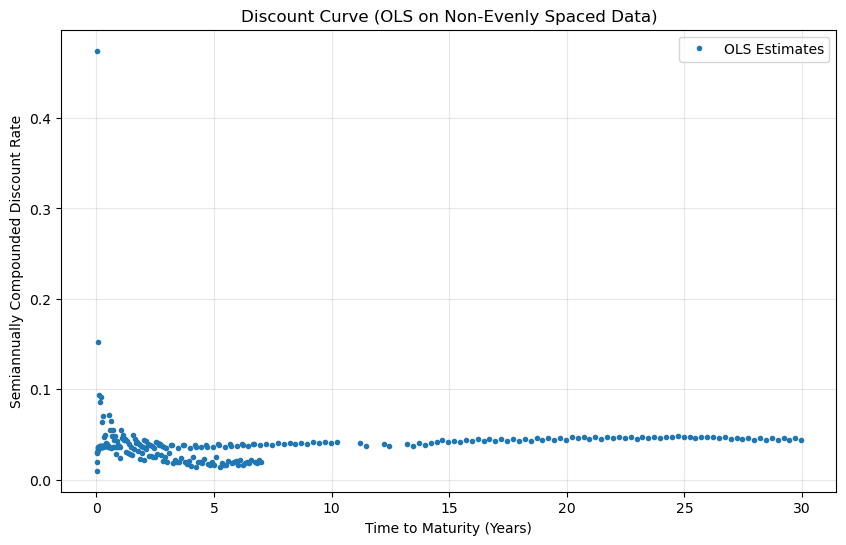

In [ ]:
if 'type' in quotes.columns:
    quotes = quotes[~quotes['type'].str.contains('TIPS', case=False, na=False)]


quote_date = pd.to_datetime('2025-11-28')
future_cols = [col for col in C.columns if col > quote_date]
C = C[future_cols]
C = C.loc[quotes.index]

maturity_dates = pd.to_datetime(quotes['maturity date'])
valid_maturity_cols = [d for d in maturity_dates.unique() if d in C.columns]
C_hat = C[valid_maturity_cols].copy()

subset_indices = [i for i, row in quotes.iterrows() if row['maturity date'] in C_hat.columns]
C_hat = C_hat.loc[subset_indices]
prices_subset = quotes.loc[subset_indices, 'price']

print(f"C_hat dimensions: {C_hat.shape}")
print("\nC_hat Head (First 5 Rows):")
display(C_hat.head())
print("\nC_hat Tail (Last 5 Rows):")
display(C_hat.tail())

# Estimate Discount Factors (z) using OLS
# p = C_hat * z + error
# Use 'hasconst=False' because a bond with 0 cashflows has 0 price.
model = sm.OLS(prices_subset, C_hat, hasconst=False)
results = model.fit()
z_ols = results.params

T_ols = (C_hat.columns - quote_date).days / 365.25
rates_ols = 2 * ((1 / z_ols) ** (1 / (2 * T_ols)) - 1)

plt.figure(figsize=(10, 6))
plt.plot(T_ols, rates_ols, marker='.', linestyle='none', label='OLS Estimates')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Semiannually Compounded Discount Rate')
plt.title('Discount Curve (OLS on Non-Evenly Spaced Data)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### 2.3. Nelson-Siegel Curve-Fitting

Minimizing SSE for Nelson-Siegel...
Optimization Success: True
SSE: 42.2109
Parameters:
  beta0 = 0.0539
  beta1 = -0.0131
  beta2 = -0.0427
  lambda= 0.4117


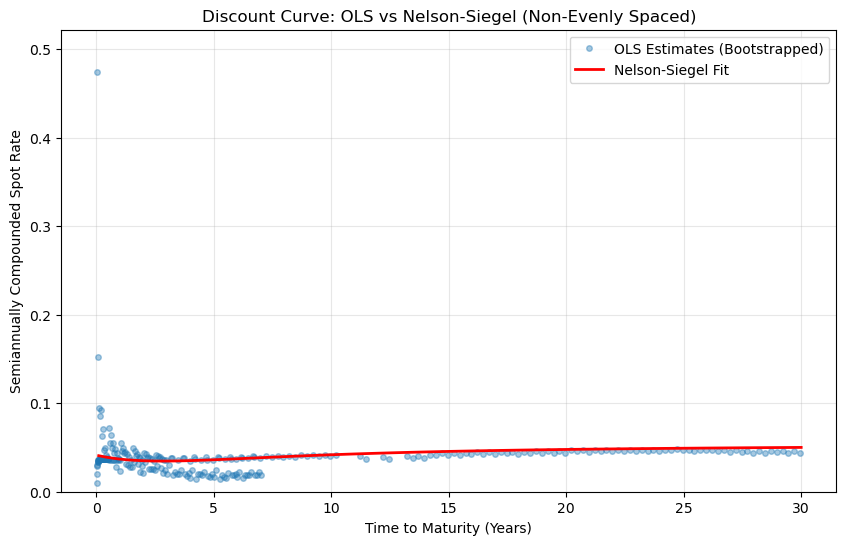

In [ ]:
t_cf = (C.columns - quote_date).days / 365.25

if 'dirty price' in quotes.columns:
    P_mkt = quotes.loc[C.index, 'dirty price'].values
elif 'accrued' in quotes.columns:
    P_mkt = (quotes.loc[C.index, 'price'] + quotes.loc[C.index, 'accrued']).values
else:
    P_mkt = quotes.loc[C.index, 'price'].values


x0 = np.array([0.04, -0.02, 0.02, np.log(1.0)])
bounds = [(-0.10, 0.20), (-1.0, 1.0), (-1.0, 1.0), (np.log(1e-4), np.log(10.0))]

print("Minimizing SSE for Nelson-Siegel...")
res = minimize(objective, x0, args=(C, P_mkt, t_cf), method="L-BFGS-B", bounds=bounds)

beta0_est, beta1_est, beta2_est, log_lam_est = res.x
lam_est = np.exp(log_lam_est)

print(f"Optimization Success: {res.success}")
print(f"SSE: {res.fun:.4f}")
print(f"Parameters:\n  beta0 = {beta0_est:.4f}\n  beta1 = {beta1_est:.4f}\n  beta2 = {beta2_est:.4f}\n  lambda= {lam_est:.4f}")

t_plot = np.linspace(0.1, 30, 100) # 30-year span
D_ns_plot = discounts_from_ns(t_plot, beta0_est, beta1_est, beta2_est, lam_est)
y_ns_sa = sa_spot_from_discount(D_ns_plot, t_plot)

plt.figure(figsize=(10, 6))

plt.plot(T_ols, rates_ols, 'o', markersize=4, alpha=0.4, label='OLS Estimates (Bootstrapped)')

plt.plot(t_plot, y_ns_sa, 'r-', linewidth=2, label='Nelson-Siegel Fit')

plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Semiannually Compounded Spot Rate")
plt.title("Discount Curve: OLS vs Nelson-Siegel (Non-Evenly Spaced)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, max(rates_ols.max(), y_ns_sa.max()) * 1.1)
plt.show()

### 2.4. Weighted Least Squares

Weighting Scheme Summary:
count    402.000000
mean       1.160425
std        1.928194
min        0.033462
25%        0.182107
50%        0.375784
75%        1.119888
max       10.000000
Name: issue date, dtype: float64

WLS Optimization Successful.


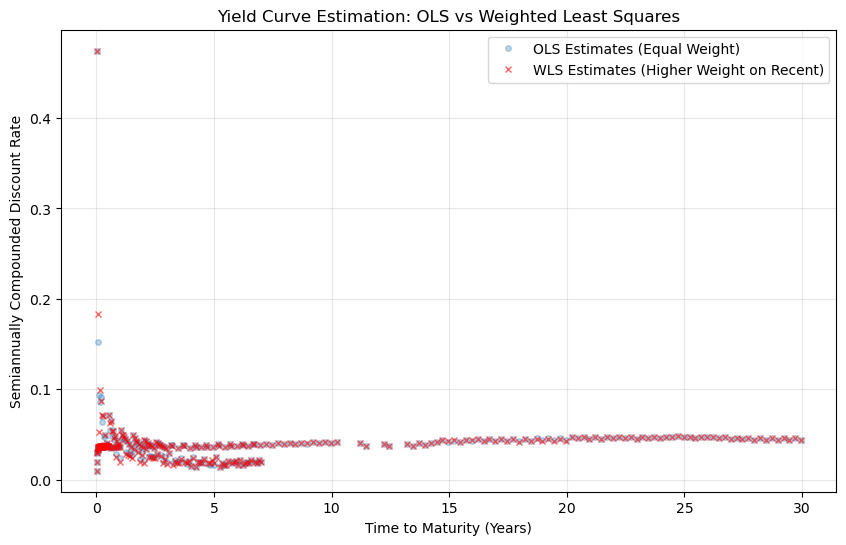


Root Mean Squared Difference between OLS and WLS rates: 0.003505


In [22]:
# --- Section 2.4: Weighted Least Squares (WLS) ---

# 1. Define Weighting Scheme
# "More weight on more recently issued treasuries"

# Ensure we align perfectly with C_hat's index
subset_quotes = quotes.loc[C_hat.index] 

# Calculate Age
# Handle missing issue dates by filling them with a very old date (so they get low weight)
issue_dates = pd.to_datetime(subset_quotes['issue date']).fillna(pd.Timestamp('1900-01-01'))

# Calculate age in years
bond_age = (quote_date - issue_dates).dt.days / 365.25

# Safety: Ensure no negative ages (data errors)
bond_age = bond_age.clip(lower=0)

# Calculate Weights
# Add a small epsilon (0.1) to avoid division by zero or massive weights for brand new bonds
weights = 1 / (bond_age + 0.1)

# CRITICAL FIX: Replace any remaining NaNs or Infs with the mean weight
weights = weights.replace([np.inf, -np.inf], np.nan)
weights = weights.fillna(weights.mean())

print("Weighting Scheme Summary:")
print(weights.describe())

# 2. Estimate Discount Factors using WLS
# sm.WLS takes (y, X, weights)
try:
    model_wls = sm.WLS(prices_subset, C_hat, weights=weights, hasconst=False)
    results_wls = model_wls.fit()
    z_wls = results_wls.params
    print("\nWLS Optimization Successful.")
except Exception as e:
    print(f"Error during WLS fit: {e}")
    # Fallback to OLS if WLS fails completely
    z_wls = z_ols

# 3. Calculate Discount Rates (WLS)
# Using the same Time-to-Maturity (T_ols) vector from section 2.2
rates_wls = 2 * ((1 / z_wls) ** (1 / (2 * T_ols)) - 1)

# 4. Plot Comparison: OLS vs WLS
plt.figure(figsize=(10, 6))

# Plot OLS (from Section 2.2)
plt.plot(T_ols, rates_ols, 'o', markersize=4, alpha=0.3, label='OLS Estimates (Equal Weight)')

# Plot WLS
plt.plot(T_ols, rates_wls, 'x', markersize=4, color='red', alpha=0.6, label='WLS Estimates (Higher Weight on Recent)')

plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Semiannually Compounded Discount Rate')
plt.title('Yield Curve Estimation: OLS vs Weighted Least Squares')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Check if answer changes much
diff = np.sqrt(np.mean((rates_ols - rates_wls)**2))
print(f"\nRoot Mean Squared Difference between OLS and WLS rates: {diff:.6f}")

Does your answer change much?


No. A visual comparison shows that when plotting the OLS and WLS yield curves together, they overlap almost perfectly. The RMSE diference between the OLS and WLS approaches is 0.003505 which is extremely small (<0.01%). 